In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [5]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [ ]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

In [6]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [7]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Get CSP Weights

In [8]:
from cspnn.csp import CSP as CSP_base

In [9]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

csp = CSP_base(list(range(1, 5)), num_bands=1, num_windows=1)

In [54]:
signale = []
label = []
for sig, lbl in csp_dataloader:
    signale.append(sig)
    label.append(lbl["label"])
signale = torch.vstack(signale)
label = torch.stack(label)

In [55]:
signale.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [12]:
weights = csp.calculate_weights(
    signals=signale.cpu().detach().numpy(), labels=label.cpu().detach().numpy()
)

In [27]:
weights.keys()

dict_keys(['label-1_band-0_window-0', 'label-2_band-0_window-0', 'label-3_band-0_window-0', 'label-4_band-0_window-0'])

In [39]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [135]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.shape[0]):
        cov.append(EEG_data[i] @ EEG_data[i].T / np.trace(EEG_data[i] @ EEG_data[i].T))

    cov = np.mean(np.array(cov), 0)

    return cov

In [233]:
signal = signale.squeeze().cpu().detach().numpy()

In [234]:
x = signal
x = calc_cov(x)
x.shape

(22, 22)

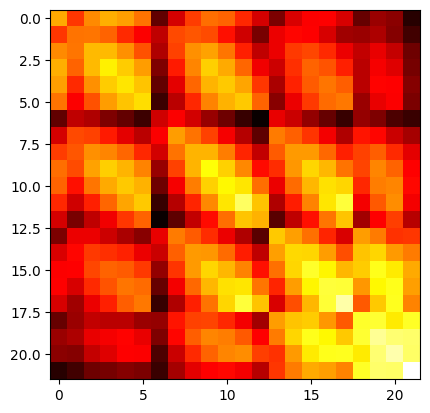

In [235]:
plt.imshow(x, cmap="hot", interpolation="nearest")
plt.show()

In [190]:
lda, V = la.eig(x)
x = signal
x = V.T @ x

x = calc_cov(x)
x.shape

(22, 22)

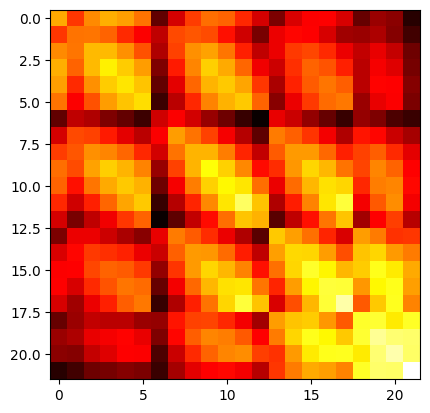

In [194]:
plt.imshow(x, cmap="hot", interpolation="nearest")
plt.show()

In [88]:
np.unique(label.cpu().detach().numpy())

array([0., 1., 2., 3.])

In [132]:
x = signal
l = label.cpu().detach().numpy()
x = x[l == 0]
x = weights["label-1_band-0_window-0"][:, :].T @ x
x.shape

(648, 22, 1001)

In [133]:
x = calc_cov(x)
x.shape

(22, 22)

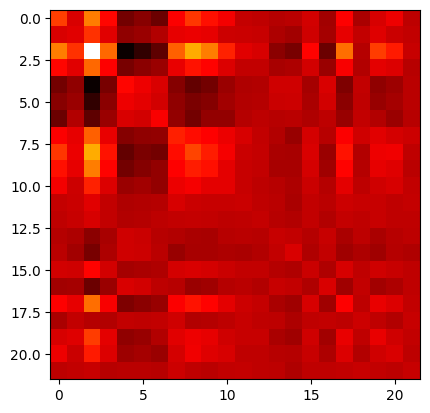

In [134]:
plt.imshow(x, cmap="hot", interpolation="nearest")
plt.show()

In [43]:
lda

array([7.73504491e-01+0.j, 1.00965334e-01+0.j, 7.16946712e-02+0.j,
       1.92050845e-02+0.j, 1.09465760e-02+0.j, 6.69467909e-03+0.j,
       3.68996201e-03+0.j, 3.03606248e-03+0.j, 2.21828022e-03+0.j,
       2.12517147e-03+0.j, 1.50657358e-03+0.j, 1.30040655e-03+0.j,
       6.98839495e-04+0.j, 4.60266156e-04+0.j, 4.16383610e-04+0.j,
       3.74075559e-04+0.j, 1.02779602e-04+0.j, 1.27061118e-04+0.j,
       2.83568977e-04+0.j, 2.61974418e-04+0.j, 1.99472880e-04+0.j,
       1.88286839e-04+0.j])

In [155]:
x_trial = signal[l == 1]
x_rest = signal[l != 1]

In [213]:
R_a = calc_cov(x_trial)
R_b = calc_cov(x_rest)
R_c = R_a + R_b

lda, V = la.eig(R_c)
W = la.sqrtm(la.inv(np.diag(lda))) @ V.T
T_a = W @ R_a @ W.T
T_b = W @ R_b @ W.T
T_c = W @ R_c @ W.T

sai, E = la.eig(T_a, T_c)
_, Ep = la.eig(T_a, T_b)
_, E_a = la.eig(R_a)
_, E_b = la.eig(R_b)

In [230]:
En = E_a @ E_b.T

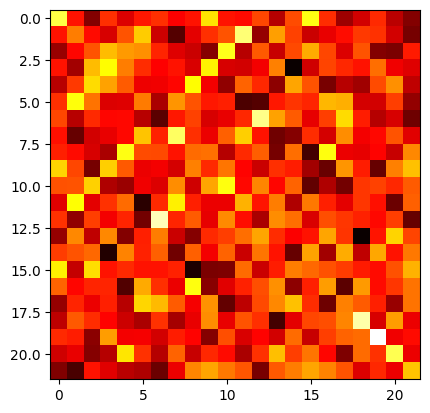

In [231]:
plt.imshow(En.real, cmap="hot", interpolation="nearest")
plt.show()

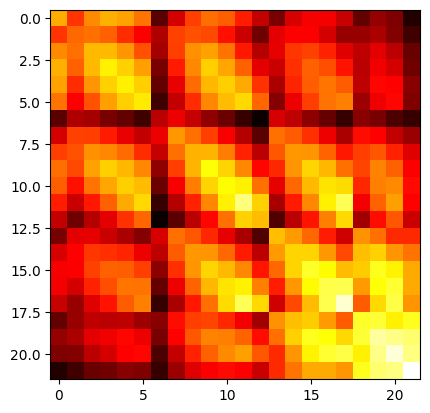

In [232]:
x = signal
# x = x[l == 1]
x = En.real.T @ x
x = calc_cov(x)

plt.imshow(x, cmap="hot", interpolation="nearest")
plt.show()

## Model

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [ ]:
import torch.optim as optim

In [ ]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [ ]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [ ]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

In [ ]:
net.conv1.load_csp_weights(weights=weights, csp_template=csp.template)

## Train Loop

In [ ]:
net = net.cuda()

In [ ]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])

In [ ]:
{k: history[k][-1] for k in history.keys()}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()